# How does it work?

Hierarchical agglomerative clustering initiate having a maximum number of clusters and starts merging them depending on the distance and type of linkage between them. As you can expect, distance plays an important role in this algorithm. Common measurements of distance between two numerical data points $x$ and $y$ are:

* Euclidean distance $D_{E} = \sqrt{\sum_{i} (x_{i} - y_{i})^{2}}$ 
    * Data points are spatial locations or have continuous features
    * Clusters are expected to be compact and spherical in shape 
    * Sensitive to scale of the data (# of features)
* Manhattan distance $D_{M} = \sum_{i}|x_{i} - y_{i}|$
    * Less sensitive to outliers
    * Features are not necessarily continuous
    * High dimensional data
* Chebyshev distance $D_{CH} = \text{max}(|x_{1} - y_{1}|, |x_{2} - y_{2}|, ..., |x_{N} - y_{N}|)$
    * Features have different scales
    * Useful for anomaly detection
* Cosine distance $D_{cos} = \frac{x \cdot y}{||x||||y||}$
    * Text data or high dimensional sparse data
    * Direction is more important than magnitude
    * Robust to the scale of the data

The type of linkage refers to how we will measure the proximity between clusters. Common types of linkage are:

* Single Linkage: Minimum distance between two clusters (closest datapoints between clusters)
* Complete Linkage: Maximum distance between two clusters (farthest datapoints between clusters)
* Centroids Linkage: Distance between the centers of the clusters
* Average Linkage: Average distance between all the points from one cluster to the other.
* Ward Linkage: Compute the inertia between clusters and pick the pair that minimize the inertia value.

Lets create a sample dataset:

Text(0.5, 1.0, 'Dataset with two features')

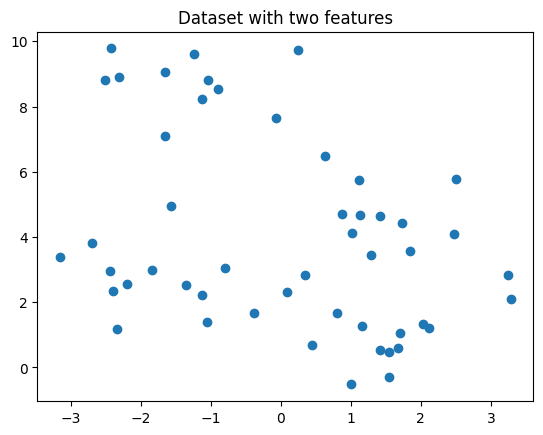

In [337]:
# Lets create a dataset from sklearn.datasets.make_blob
# We will use a small dataset so we can visualize better the process
## Create sample dataset with sklearn 
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

n_samples = 50
n_features = 2
n_classes = 4

data =  make_blobs(n_samples = n_samples, 
                   n_features = n_features, 
                   centers = n_classes,
                   random_state = 0)
feature_data = data[0]
plt.scatter(feature_data[:, 0], feature_data[:, 1])
plt.title('Dataset with two features')

For this case we will use the euclidean distance and the single Linkage.

Lets create functions to calculate both values.

In [338]:
import numpy as np
def euclidean_distance(x, y):
    return np.linalg.norm(x - y) # The norm is directly the euclidean distance

def single_linkage(A, B):
    dist_mat = np.zeros([len(A), len(B)])
    for ii in range(len(A)):
        for jj in range(len(B)):
            dist_mat[ii, jj] = euclidean_distance(A[ii], B[jj])

    min_dist = dist_mat.min()
    loc_A, loc_B = np.unravel_index(np.argmin(dist_mat), dist_mat.shape)
    return min_dist, loc_A, loc_B

We have classes predetermined, we will use two of them just to test if the functions work.

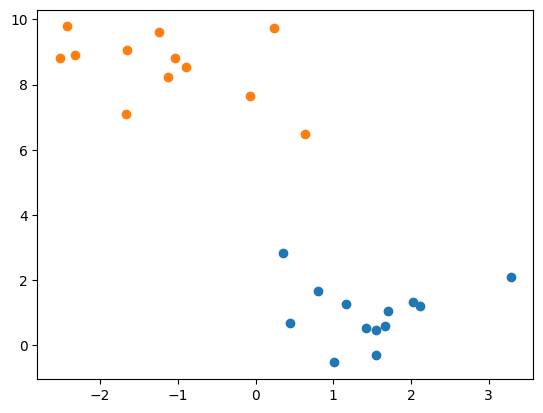

In [339]:
#Create two groups A and B
A = feature_data[data[1] == 1]
B = feature_data[data[1] == 3]

plt.scatter(A[:, 0], A[:, 1])
plt.scatter(B[:, 0], B[:, 1])

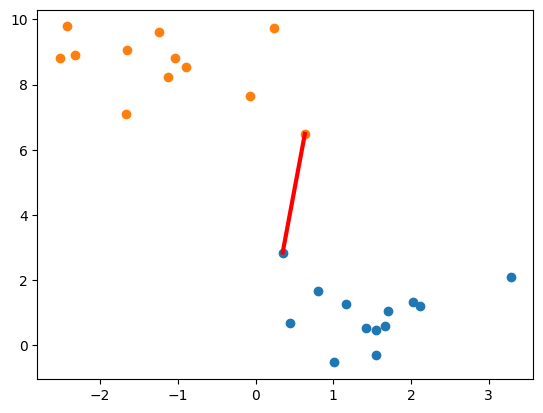

In [340]:
# Test the single_leakage function and plot a line connecting the points
min_dist, loc_A, loc_B = single_linkage(A, B)

plt.scatter(A[:, 0], A[:, 1])
plt.scatter(B[:, 0], B[:, 1])

plt.plot([A[loc_A][0], B[loc_B][0]], [A[loc_A][1], B[loc_B][1]], c = 'red', linewidth = 3 )


And it works just fine! Now we can use this for our algorithm

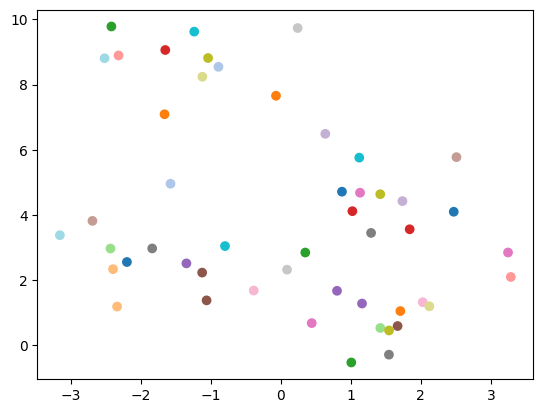

In [341]:
# Define a class for each point

classes = np.array([ii for ii in range(len(feature_data))])
colors = plt.cm.tab20(classes/len(classes)) # This is an (R, G, B, \alpha) for each class

plt.scatter(feature_data[:, 0], feature_data[:, 1], c = colors)

Text(0.5, 1.0, 'After Step')

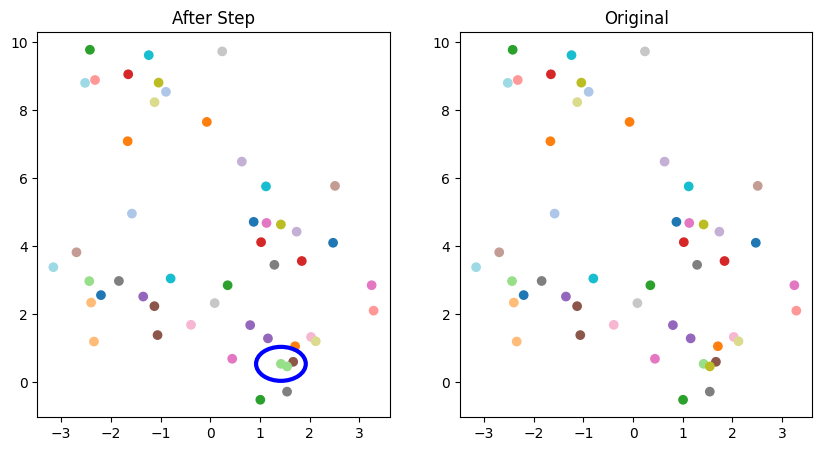

In [305]:

# Original figure 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax2.scatter(feature_data[:, 0], feature_data[:, 1], c = colors)
ax2.set_title('Original')
# Create a matrix with infinite values, this way we won't select
# any of the infinite values as a position

len_data = len(feature_data)
distances = np.full((len_data, len_data), np.inf)


# Calculate the minimum distance between each pair of classes

for ii in range(len_data-1):
    for jj in  range(len_data - ii - 1):
        if classes[ii] != classes[ii+jj+1]:
            A = feature_data[classes == classes[ii]]
            B = feature_data[classes == classes[ii+jj+1]]
            min_dist, loc_A, loc_B =  single_linkage(A, B)
            distances[ii, ii+jj+1] = min_dist

# Select the two clustes with least distance
min_A, min_B = np.unravel_index(np.argmin(distances), distances.shape)

# Replace classes and colors
classes[classes == classes[min_B]] = classes[min_A]
colors = plt.cm.tab20(classes/len(classes))

# Plot the scatter with new classes
ax1.scatter(feature_data[:, 0], feature_data[:, 1], c = colors)
circle = plt.Circle((feature_data[min_A, 0], feature_data[min_A, 1]), 0.5, color = "blue", fill = False, linewidth = 3)
ax1.add_patch(circle)
ax1.set_title('After Step')

As we can see in the blue circle, after the first step the two closest clusters (by single leakage) got merged into one class. Lets repeat this process and show it.

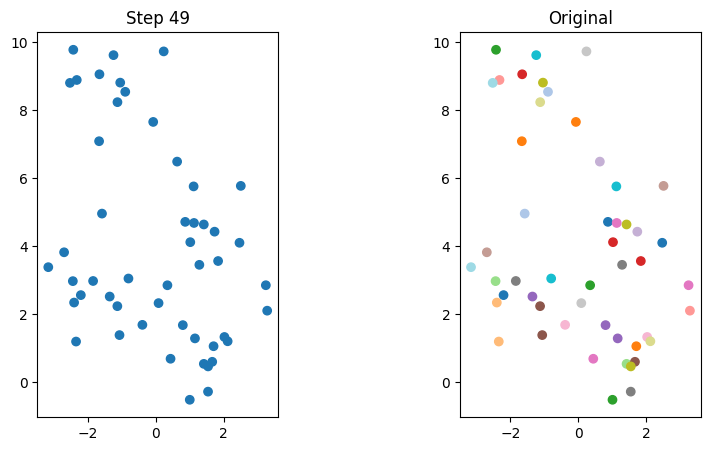

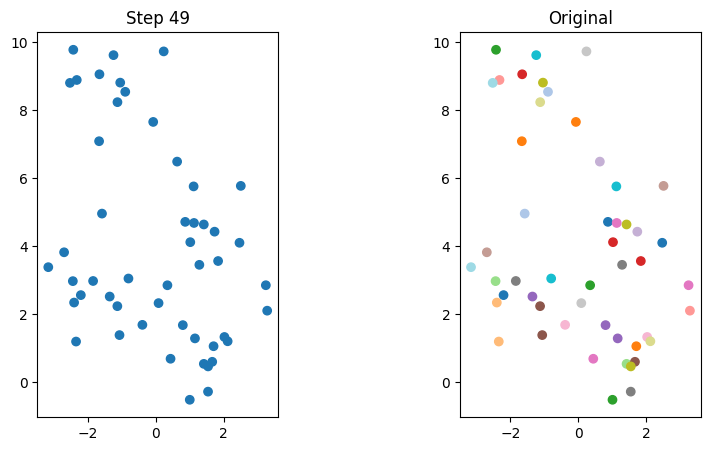

In [307]:
import time
from IPython.display import clear_output, display

# Initiate classes
classes = np.array([ii for ii in range(len(feature_data))])
colors = plt.cm.tab20(classes/len(classes)) # This is an (R, G, B, \alpha) for each class

# Original figure
plt.ion()  # Turn on interactive mode
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax2.scatter(feature_data[:, 0], feature_data[:, 1], c = colors)
ax2.set_title('Original')
ax2.set_aspect('equal')

# Draw the left figure 
class_progress = ax1.scatter(feature_data[:, 0], feature_data[:, 1], c = colors)
ax1.set_aspect('equal')
# Create a matrix with infinite values, this way we won't select
# any of the infinite values as a position

len_data = len(feature_data)

for step in range(50):
    distances = np.full((len_data, len_data), np.inf)

    # Calculate the minimum distance between each pair of classes

    for ii in range(len_data-1):
        for jj in  range(len_data - ii - 1):
            if classes[ii] != classes[ii+jj+1]:
                A = feature_data[classes == classes[ii]]
                B = feature_data[classes == classes[ii+jj+1]]
                min_dist, loc_A, loc_B =  single_linkage(A, B)
                distances[ii, ii+jj+1] = min_dist

    # Select the two clustes with least distance
    min_A, min_B = np.unravel_index(np.argmin(distances), distances.shape)

    # Replace classes and colors
    classes[classes == classes[min_B]] = classes[min_A]
    colors = plt.cm.tab20(classes/len(classes))

    # Update the scatter with new classes
    class_progress.set_color(colors)
    circle.set_center((feature_data[min_A, 0], feature_data[min_A, 1]))
    ax1.set_title(f'Step {step}')

    clear_output(wait=True)
    
    display(fig)
    time.sleep(0.5)

This process works but we need to stop somewhere. We can utilize the same method of K-means where we calculate the inertia and use the "elbow method" to identify the optimal number of clusters. We will save both how classes are splitted and the inertia for each step, then we will pick the best number of clusters. 

In [308]:
# This will calculate the inertia
def inertia_fun(data, classes):
    unique_classes = set(classes)
    inertia = 0
    for cls in unique_classes:
        centroids = data[classes == cls].mean(axis = 0)
        inertia += (np.linalg.norm(data[classes == cls] - centroids, axis = 1)**2).sum()
    return inertia

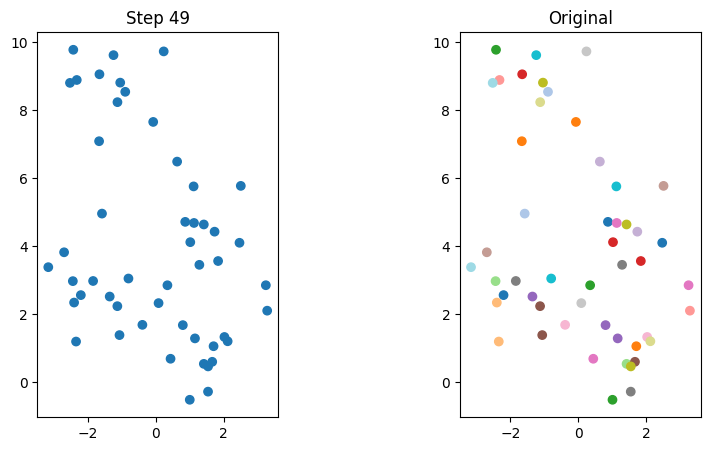

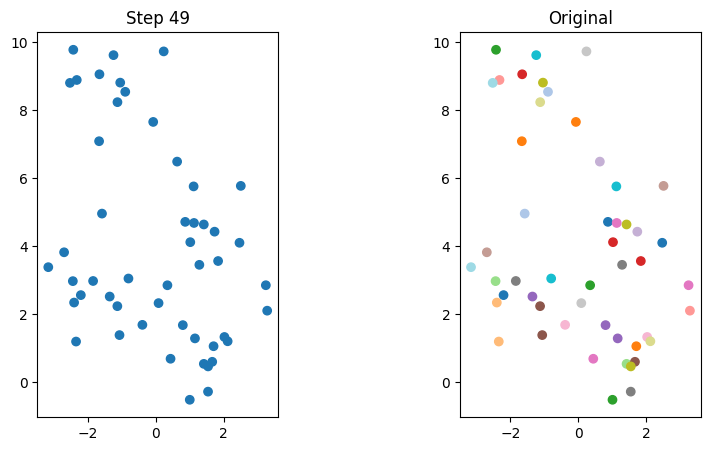

In [310]:
import time
from IPython.display import clear_output, display

classes_k = [] # Here we will save the data
inertia = [] # Here we will save the inertia
n_classes = [] # The number of classes in each step

# Initiate classes
classes = np.array([ii for ii in range(len(feature_data))])
classes_k.append(classes)
n_classes.append(len(set(classes)))
inertia.append(inertia_fun(feature_data, classes))

colors = plt.cm.tab20(classes/len(classes)) # This is an (R, G, B, \alpha) for each class

# Original figure
plt.ion()  # Turn on interactive mode
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax2.scatter(feature_data[:, 0], feature_data[:, 1], c = colors)
ax2.set_title('Original')
ax2.set_aspect('equal')

# Draw the left figure 
class_progress = ax1.scatter(feature_data[:, 0], feature_data[:, 1], c = colors)
ax1.set_aspect('equal')
# Create a matrix with infinite values, this way we won't select
# any of the infinite values as a position

len_data = len(feature_data)

for step in range(50):
    distances = np.full((len_data, len_data), np.inf)

    # Calculate the minimum distance between each pair of classes

    for ii in range(len_data-1):
        for jj in  range(len_data - ii - 1):
            if classes[ii] != classes[ii+jj+1]:
                A = feature_data[classes == classes[ii]]
                B = feature_data[classes == classes[ii+jj+1]]
                min_dist, loc_A, loc_B =  single_linkage(A, B)
                distances[ii, ii+jj+1] = min_dist

    # Select the two clustes with least distance
    min_A, min_B = np.unravel_index(np.argmin(distances), distances.shape)

    # Replace classes and colors
    classes[classes == classes[min_B]] = classes[min_A]
    classes_k.append(classes)
    n_classes.append(len(set(classes)))
    inertia.append(inertia_fun(feature_data, classes))

    colors = plt.cm.tab20(classes/len(classes))

    # Update the scatter with new classes
    class_progress.set_color(colors)
    circle.set_center((feature_data[min_A, 0], feature_data[min_A, 1]))
    ax1.set_title(f'Step {step}')

    clear_output(wait=True)
    
    display(fig)
    time.sleep(0.5)

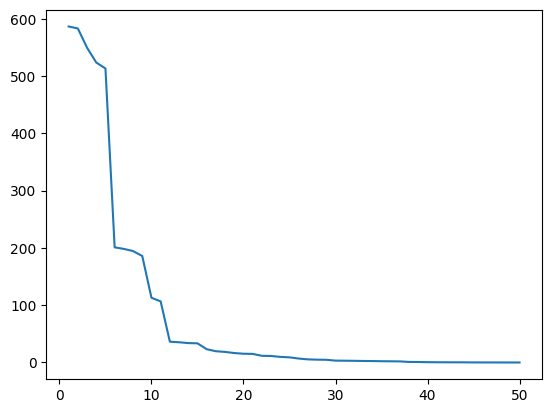

In [311]:
plt.plot(n_classes, inertia)

And by the elbow method we would choose the 6 clusters. This is not the same as the original number of clusters set (4) but we have only 50 datapoints and the data is way to scattered over the domain. I can't tell which should be a good division of the clusters. Let's try again with more points (this time without animation to avoid long time of waiting)

Text(0.5, 1.0, 'Dataset with two features')

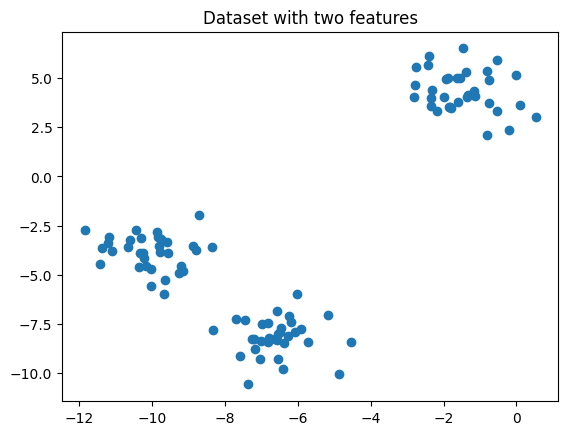

In [344]:
# Lets create a dataset from sklearn.datasets.make_blob
# We will use a small dataset so we can visualize better the process
## Create sample dataset with sklearn 
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

n_samples = 100
n_features = 2
n_classes = 3

data =  make_blobs(n_samples = n_samples, 
                   n_features = n_features, 
                   centers = n_classes,
                   random_state = 1)
feature_data = data[0]
plt.scatter(feature_data[:, 0], feature_data[:, 1])
plt.title('Dataset with two features')

For my computer the next code took about 1 hr to execute. This method scales pretty slow for large amounts of data, also my code isn't as efficient as possible since it is only for learning purposes (I suggest using sklearn built-in function instead).

In [349]:
from tqdm import tqdm # This shows a progress bar of the for loop

classes_k = [] # Here we will save the data
inertia = [] # Here we will save the inertia
n_classes = [] # The number of classes in each step

# Initiate classes
classes = np.array([ii for ii in range(len(feature_data))])
classes_k.append(classes)
n_classes.append(len(set(classes)))
inertia.append(inertia_fun(feature_data, classes))

colors = plt.cm.tab20(classes/len(classes)) # This is an (R, G, B, \alpha) for each class

len_data = len(feature_data)

for step in tqdm(range(len_data)):
    distances = np.full((len_data, len_data), np.inf)

    # Calculate the minimum distance between each pair of classes

    for ii in range(len_data-1):
        for jj in  range(len_data - ii - 1):
            if classes[ii] != classes[ii+jj+1]:
                A = feature_data[classes == classes[ii]]
                B = feature_data[classes == classes[ii+jj+1]]
                min_dist, _, _=  single_linkage(A, B)
                distances[ii, ii+jj+1] = min_dist

    # Select the two clustes with least distance
    min_A, min_B = np.unravel_index(np.argmin(distances), distances.shape)

    # Replace classes and colors
    classes[classes == classes[min_B]] = classes[min_A]
    classes_k.append(classes)
    n_classes.append(len(set(classes)))
    inertia.append(inertia_fun(feature_data, classes))

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [04:45<00:00,  2.86s/it]


And plot again the inertia, 

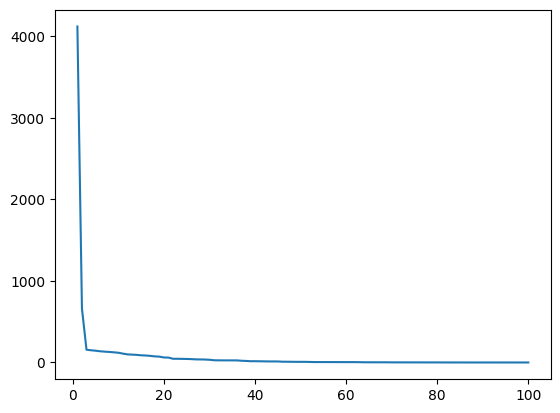

In [350]:
plt.plot(n_classes, inertia)

Lets close up

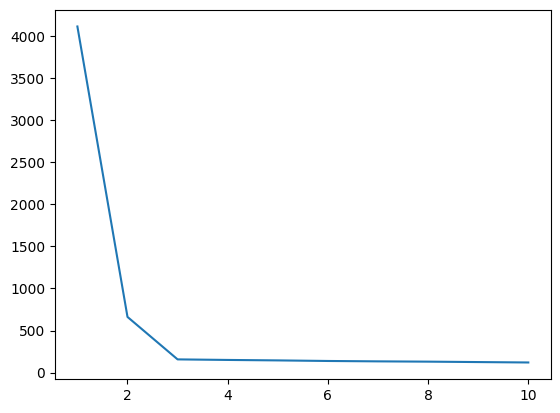

In [352]:
plt.plot(n_classes[90:], inertia[90:])

In this case the elbow method says that the best number of clusters is two (instead of the 3 initialized at the begginning)